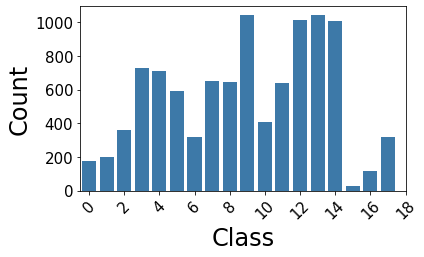

Got 10000  data  samples. Hyperparameters were: f-> [ 10  75 250] x [0.125 0.175 0.225] err [0.5 1. ]
------------------Printing stats for main generator------------------
f,x,err,count
0-0-0 174
0-0-1 1043
0-1-0 201
0-1-1 407
0-2-0 363
0-2-1 639
1-0-0 728
1-0-1 1015
1-1-0 710
1-1-1 1043
1-2-0 593
1-2-1 1010
2-0-0 318
2-0-1 28
2-1-0 649
2-1-1 115
2-2-0 644
2-2-1 320
Total number of samples: 10000


In [1]:
from data_generator_sigma_err import *
main(['', 'exp5'])